# Generative MGGD Spatial Model
1. Stochastic representation: $\mathbf{x} = \tau \Sigma^{1/2} \mathbf{u}, \mathbf{u} \in \mathbb{R}^2$
2. Scatter matrix $\Sigma = m \mathbf{M}$
3. Shape parameter $\beta$
4. $\tau^{2 \beta} \sim \Gamma(\frac{p}{2 \beta}, 2)$

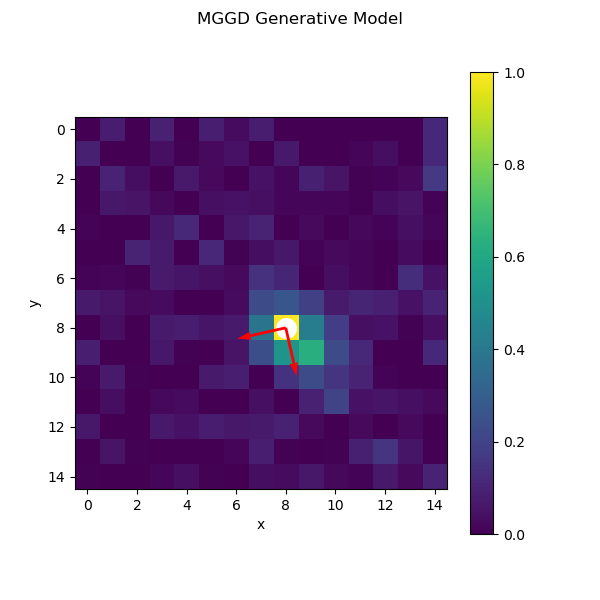

In [1]:
%matplotlib widget
from random import random

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from numpy import linalg as LA
from scipy.optimize import minimize


def genScatter(alpha=None, p=2):
    if alpha is None:
        alpha = random() * 2 * np.pi
    beta = alpha + np.pi / 2.0

    Q = np.array([[np.cos(alpha), np.cos(beta)], [np.sin(alpha), np.sin(beta)]])
    P = np.diag(np.random.rand(2))
    M = np.matmul(np.matmul(Q, P), LA.inv(Q))

    return M * p / M.trace()


def normalize2(xs, scope, dtype=int):
    xs = (xs - xs.min()) / (xs.max() - xs.min()) * (scope - 1)
    return np.clip(np.round(xs), 0, scope - 1).astype(dtype)


def generate_image(beta, m, M, p=2):
    nsamples = 1000
    # Stochastic process
    Sigma = np.sqrt(np.abs(m * M))
    phi = 2 * np.pi * np.random.random(nsamples) - np.pi
    u = np.array([np.cos(phi), np.sin(phi)])
    tau = np.power(np.random.gamma(0.5 * p / beta, 2, nsamples), 0.5 / beta)
    x = tau * np.matmul(Sigma, u)

    x = normalize2(x, 15)

    im = np.zeros((15, 15), dtype=int)
    for ns in np.arange(nsamples):
        im[x[0, ns], x[1, ns]] += 1
    noise = np.random.normal(np.mean(im), 0.5 * np.sqrt(np.var(im)), im.shape)
    im += np.round(noise).astype(int)
    im[im < 0] = 0
    im = (im - im.min()) / (im.max() - im.min())

    X, Y = np.meshgrid(np.linspace(1, 16, 15), np.linspace(1, 16, 15))
    center = (
        np.round(np.sum(X * im / np.sum(im))) - 1,
        np.round(np.sum(Y * im / np.sum(im))) - 1,
    )
    w, v = LA.eig(M)
    X = [center[1], center[1]]
    Y = [center[0], center[0]]
    U = v[0, :]
    V = v[1, :]

    return im, center, v


fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_aspect(1)
ax.set_xlabel("x")
ax.set_ylabel("y")
im, center, v = generate_image(0.5, 10, genScatter())
image = ax.imshow(im)
scatter = ax.scatter(center[1], center[0], s=200, c="w")
quiver = ax.quiver(
    [center[1], center[1]],
    [center[0], center[0]],
    v[0, :],
    v[1, :],
    color="r",
    scale_units="xy",
    scale=0.5,
)
fig.colorbar(image, ax=ax)


def init():
    im, center, v = generate_image(
        np.random.rand(1) * 6, np.random.rand(1) * 15, genScatter()
    )
    image.set_data(im)
    scatter.set_offsets(center)
    quiver.set_offsets(np.asarray([center, center]))
    quiver.set_UVC(v[0, :], v[1, :])

    return image, dot, quiver


def update(frame):
    beta = np.random.rand(1) * 6
    im, center, v = generate_image(beta, np.random.rand(1) * 15, genScatter())
    image.set_data(im)
    scatter.set_offsets(center)
    quiver.set_offsets(np.asarray([center, center]))
    quiver.set_UVC(v[0, :], v[1, :])
    ax.set_title(r"$\beta = $ %.1f" % beta[0])

    return image, dot, quiver


ani = FuncAnimation(fig, update, frames=100, interval=400, init_func=init, blit=True)

plt.suptitle("MGGD Generative Model")
plt.show()

# MGG Spatial Model Parameter Estimation with SNN in Nengo

In [4]:
import nengo
import numpy as np
import tensorflow as tf
from scipy.optimize import minimize

d = 2

# Parameter estimation with max log-likelihood
class MultiVarGenGaussian:
    def __init__(self, mu, Sigma, beta):
        self.mu = mu
        self.Sigma = Sigma
        self.beta = beta

    def pdf(self, X):
        d = X.shape[1]
        diff = X - self.mu
        exponent = -0.5 * np.sum(
            np.power(np.dot(diff, np.linalg.inv(self.Sigma)), 2), axis=1
        )
        exponent = np.power(1 + exponent / self.beta, -(self.beta + d) / 2)
        return np.prod(exponent)

    def log_likelihood(self, X):
        return np.sum(np.log(self.pdf(X)))


# Parameter estimation with neural sampling
class MultiVarGenGaussian:
    def __init__(self, mu, Sigma, alpha):
        self.mu = mu
        self.Sigma = Sigma
        self.alpha = alpha

    def log_pdf(self, X):
        d = tf.shape(X)[1]
        diff = X - self.mu
        exponent = -0.5 * tf.reduce_sum(
            tf.square(tf.matmul(diff, tf.linalg.inv(self.Sigma))), axis=1
        )
        exponent = tf.pow(1 + exponent / self.alpha, -(self.alpha + d) / 2)
        return tf.reduce_sum(tf.log(exponent))


def estimate_params(X, num_samples=1000):
    n, d = X.shape
    mu0 = np.mean(X, axis=0)
    Sigma0 = np.cov(X.T)
    alpha0 = tf.Variable(1.0, dtype=tf.float32)
    model = MultiVarGenGaussian(mu0, Sigma0, alpha0)
    optimizer = tf.optimizers.Adam(learning_rate=0.1)

    @tf.function
    def sample_and_optimize():
        with tf.GradientTape() as tape:
            samples = tf.random.normal(mean=mu0, stddev=Sigma0, shape=(num_samples, d))
            log_pdf = model.log_pdf(samples)
            loss = -log_pdf
        grads = tape.gradient(loss, [alpha0])
        optimizer.apply_gradients(zip(grads, [alpha0]))
        return loss

    for i in range(100):  # number of optimization steps
        loss = sample_and_optimize()

    model.alpha = alpha0.numpy()
    return model


def estimate_params(X):
    n, d = X.shape
    mu0 = np.mean(X, axis=0)
    Sigma0 = np.cov(X.T)
    beta0 = 1.0
    model = MultiVarGenGaussian(mu0, Sigma0, beta0)
    res = minimize(lambda beta: -model.log_likelihood(X), beta0, method="BFGS")
    beta_hat = res.x[0]
    model.beta = beta_hat
    return model


# Define the network
with nengo.Network() as net:
    # Input layer
    inp = nengo.Node([0] * d)

    # Ensemble for processing the input
    ens = nengo.Ensemble(n_neurons=100, dimensions=d)

    # Connect the input layer to the ensemble
    # Apply STDP to the connection
    voja = nengo.Voja(learning_rate=5e-2, post_synapse=None)
    conn = nengo.Connection(inp, ens, learning_rule_type=voja)

    # Output layer
    out = nengo.Node(size_in=d)

    # Connect the ensemble to the output layer
    nengo.Connection(ens, out)

# Simulate the network
with nengo.Simulator(net) as sim:
    sim.run(10)

X = (
    np.random.randn(100, 2) + 1
)  # generate 100 samples from a 2-dimensional normal distribution
model = estimate_params(X)

2023-02-09 13:10:45.117220: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-09 13:10:46.618226: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-09 13:10:46.618309: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-09 13:10:46.618315: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

AttributeError: 'MultiVarGenGaussian' object has no attribute 'log_likelihood'